In [46]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob 

from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Prepare object points
nx = 9 # Number of inside corners in any given row
ny = 6 # Number of inside corners in any given column

# Read in and make a list of calibration images

# glob allows us to read in files with consistent file names
# e.g. calibration-1.jpg, calibration-2.jpg...
images = glob.glob("camera_cal/calibration*.jpg")

# Initialise image and object point arrays
objpoints = []
imgpoints = []

# Generate object points
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates

for fname in images:

    # Read in image
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    # Parameters: (image, chessboard dims, param for any flags)
    # chessboard dims = inside corners, not squares.
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # Fill image point and object point arrays
        imgpoints.append(corners)
        objpoints.append(objp)

In [47]:
# Helper functions tab. Proceed to next tab to see the rest of the code. This one is a little long!!  

# Undistort image. 
def image_undistort(img): # Generic function to undistort a given image. 
    """Returns undistorted image."""
    # Calibrate the camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    # Undistort the image
    undistorted_image = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted_image


def region_of_interest(img): # to obtain region of interest (polygon for consideration.)
    if len(img.shape) > 2: # if colored image
        channel_count = img.shape[2]  # i.e. number of channels
        ignore_mask_color = (255,) * channel_count # apply white to all of it
    else:
        ignore_mask_color = 255
    imshape = img.shape
    xbottomleftlimit=imshape[1]*0.1
    xbottomrightlimit=imshape[1]*0.9
    xtopleftlimit=imshape[1]*0.45
    xtoprightlimit=imshape[1]*0.55
    ytoplimit=imshape[0]*0.60  # vertices of polygon for masking (general, for any given image). 
    mask = np.zeros_like(img)
    region = np.array([[(xbottomleftlimit, imshape[0]),(xtopleftlimit, ytoplimit), (xtoprightlimit, ytoplimit), (xbottomrightlimit,imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, region, ignore_mask_color)
    return cv2.bitwise_and(img, mask), ignore_mask_color
    
# obtain perspective transform.
def perspective_transform(img):
    masked_image, ignore_mask_color = region_of_interest(img)
    imshape = img.shape
    src = np.float32([
            (585, 455),
            (695, 455),
            (1080, 700),
            (200, 700)
        ])
    dst = np.float32([
            (450, 0),
            (830, 0),
            (830, 700),
            (450, 700)
        ])                      # obtained the values from online resources for accuracy purposes.
    M = cv2.getPerspectiveTransform(src, dst)
    warp = cv2.warpPerspective(masked_image, M, (img.shape[0:2][1], img.shape[0:2][0]), flags=cv2.INTER_LINEAR)
    mask = np.zeros_like(img)
    work_area2 = np.array([[(imshape[1]/4, 0), (imshape[1]/4*3, 0), (imshape[1]/3*2, imshape[0]), (imshape[1]/3, imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, work_area2, ignore_mask_color)
    return cv2.bitwise_and(warp, mask)

def thresholded_binary(img, s_thresh=(170, 255), sx_thresh=(20, 100), sobel_kernel=3):
    img = np.copy(img)
    # Convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x on L channel to obtain x gradient
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    abs_sobelx = np.sqrt(sobelx**2)
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))    
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold S channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Combine
    binary = np.zeros_like(sxbinary)
    binary[(sxbinary == 1) | (s_binary == 1)] = 1
    return binary


def draw_lane_curves(img): # plot histogram and simultaneously measure radius of curvatures. 
    
    # below is the find_lane_pixels function used in the lessons.  
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Set the width of the windows +/- margin
    margin = 20 #50
    # Set minimum number of pixels found to recenter window
    minpix = 100
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)

    # Choose the number of sliding windows
    nwindows = 25 #9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
   
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Calculate curvature
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Calculate the points for the left and right sides of the fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    left_line_window = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_window = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    
    # Verify if we have to correct one of the lanes, based on curvature ratio
    curverad_ratio = left_curverad / right_curverad
    left_base = left_line_window[0][left_line_window[0].shape[0]-1-40][0]
    right_base = right_line_window[0][40][0]
    base_delta = (right_base - left_base)
    replace_left = False
    replace_right = False
    if curverad_ratio <= 1/3:
        # Left side is 4x as curved as right side, let's discard the left side
        replace_left = True
    elif curverad_ratio >= 3:
        # Right side is 4x as curved as right side, let's discard the right side
        replace_right = True
    elif (left_fit[0] < 0 and right_fit[0] > 0) or (left_fit[0] > 0 and right_fit[0] < 0):
        # Lines diverge, take the one with the smallest curvature
        replace_left = left_curverad > right_curverad
        replace_right = not(replace_left)
    if replace_left:
        left_line_window = ((np.array([np.flipud(right_line_window[0])]) - [base_delta, 0]) * [1, 0]) + (left_line_window * [0, 1])
        left_curverad = right_curverad
    elif replace_right:
        right_line_window = ((np.array([np.flipud(left_line_window[0])]) + [base_delta, 0]) * [1, 0]) + (right_line_window * [0, 1])
        right_curverad = left_curverad

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*0
    
    # Paint the polynomial and the lane data that took us there
    lane_pts = np.hstack((left_line_window, right_line_window))
    cv2.fillPoly(out_img, np.int_([lane_pts]), (0, 230, 0))
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [200, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 200]
    
    # Crop the top, where most of the noise happens
    imshape = out_img.shape
    top = np.array([[(imshape[1]/4, 0), (imshape[1]/4*3, 0), (imshape[1]/4*3, imshape[0]/10), (imshape[1]/4, imshape[0]/10)]], dtype=np.int32)
    cv2.fillPoly(out_img, top, [0, 0, 0])
    
    # Calculate offset
    offset = ((imshape[1] / 2) - ((left_base + right_base) / 2)) * xm_per_pix
    
    # Return results
    polynomial_fit = np.array([left_fit, right_fit])
    
    return out_img, polynomial_fit, left_curverad, right_curverad, offset

def plot_back(img, lanes): # plots back the estimated lines onto the lanes on the original image/video 
    src = np.float32([
            (450, 0),
            (830, 0),
            (830, 700),
            (450, 700)
        ])
    dst = np.float32([
            (585, 455),
            (695, 455),
            (1080, 700),
            (200, 700)
        ])                # obtained the values from online resources for accuracy purposes.
    M = cv2.getPerspectiveTransform(src, dst)
    lanes = cv2.warpPerspective(lanes, M, (img.shape[0:2][1], img.shape[0:2][0]), flags=cv2.INTER_LINEAR)
    
    extrapolated = cv2.addWeighted(img, 1, lanes, 0.8, 0) # extrapolation, as done in the first project.
    
    return extrapolated


In [48]:
# Main processing function .
def img_processor(img):
    imshape = (img.shape[1], img.shape[0])

    undistorted_image = image_undistort(img) # step 1
    binary_image = thresholded_binary(undistorted_image) # step 2
    warped_image = perspective_transform(binary_image) # Step 3
    
    lanes, polynomial_fit, left_curverad, right_curverad, offset = draw_lane_curves(warped_image)
    text = "Left curve Radius: " + str(left_curverad)
    cv2.putText(undistorted_image, text, (25,40), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 2)
    text = "Right curve Radius: " + str(right_curverad)
    cv2.putText(undistorted_image, text, (25,80), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 2)
    text = "Offset value: " + str(offset)
    cv2.putText(undistorted_image, text, (25,120), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 2)
    return plot_back(undistorted_image, lanes)

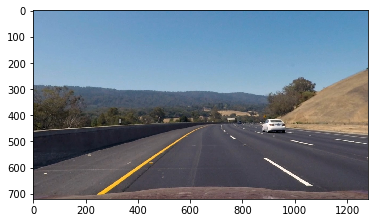

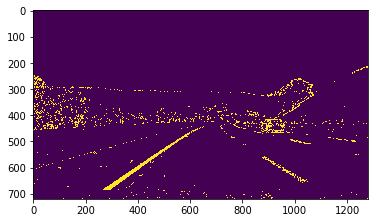

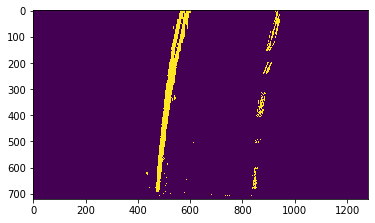

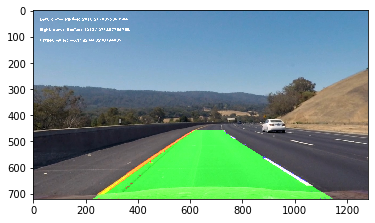

<Figure size 432x288 with 0 Axes>

In [60]:
# Cell for testing on sample images.  

test_img = mpimg.imread("test_images/test3.jpg") # Change input filename as desired. 


test_undistorted = image_undistort(test_img)
plt.imshow(test_undistorted)
plt.show() # First, we undistort

test_binary = thresholded_binary(test_img)
plt.imshow(test_binary)
plt.show() # Then we do binary thresholding

test_warped_image = perspective_transform(test_binary)
plt.imshow(test_warped_image)
plt.show() # Then the perspective warping. 

lanes, polynomial_fit, left_curverad, right_curverad, offset = draw_lane_curves(test_warped_image)
text = "Left curve Radius: " + str(left_curverad)
cv2.putText(test_undistorted, text, (25,40), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 2)
text = "Right curve Radius: " + str(right_curverad)
cv2.putText(test_undistorted, text, (25,80), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 2)
text = "Offset value: " + str(offset)
cv2.putText(test_undistorted, text, (25,120), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 2)
test_processed_img = plot_back(test_undistorted, lanes)


plt.imshow(test_processed_img)
plt.show()# final result

plt.savefig('output_images/test_result_4.jpg') # Change name of output file as required.

In [50]:

def process_image(image): # accesed by each frame in the video stream.  
    result = img_processor(image)
    return result

if __name__ == "__main__":
    print("Processing begins...")
    output_video = 'project_output_video.mp4'
    original_clip = VideoFileClip("processed_project_video.mp4")
    processed_clip = original_clip.fl_image(process_image)
    processed_clip.write_videofile(output_video, audio=False)
    print("Fin.")

Processing begins...
Moviepy - Building video challenge_output.mp4.
Moviepy - Writing video challenge_output.mp4



Moviepy - Done !
Moviepy - video ready challenge_output.mp4
Fin.
